<a href="https://colab.research.google.com/github/TheMrGhostman/Self-Driving-Car-Behavioral-Cloning-/blob/master/Behavioral_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 10.88 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [0]:
!ls track

driving_log.csv  IMG


In [0]:
!pip install imgaug

    100% |████████████████████████████████| 17.3MB 2.5MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
import cv2
import pandas as pd
import random
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

In [0]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg   

                                                                   left  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg   

                                                                   right  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.649786  
1  0.0       0.0       0.0      0.627942  
2  0.0       0.0       0.0      0.622910  
3  0.0       0.0       0.0      0.619162  
4  0.0       0.0       0.0      0.615438

In [0]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)

data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg  0.0       0.0       0.0      0.649786  
1  right_2018_07_16_17_11_43_670.jpg  0.0       0.0       0.0      0.627942  
2  right_2018_07_16_17_11_43_724.jpg  0.0       0.0       0.0      0.622910  
3  right_2018_07_16_17_11_43_792.jpg  0.0       0.0       0.0      0.619162  
4  right_2018_07_16_17_11_43_860.jpg  0.0       0.0       0.0      0.615438

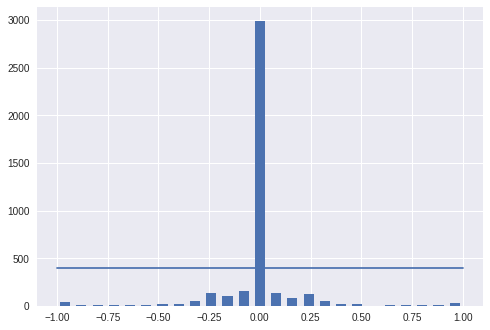

In [0]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * .5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
print(f'total_data: {len(data)}')
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
    
print(f'removed: {len(remove_list)}')
data.drop(data.index[remove_list], inplace=True)
print(f'remaining: {len(data)}')

hist,_ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin), c='red')

total_data: 4053
removed: 2590
remaining: 1463


In [0]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(indexed_data[3])
    image_path = np.asarray(image_path)
    steering = np.asarray(steering)
    return image_path, steering

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print(f'Training samples: {len(X_train), len(X_valid)}')

Training samples: (1170, 293)


Text(0.5, 1.0, 'Validation set')

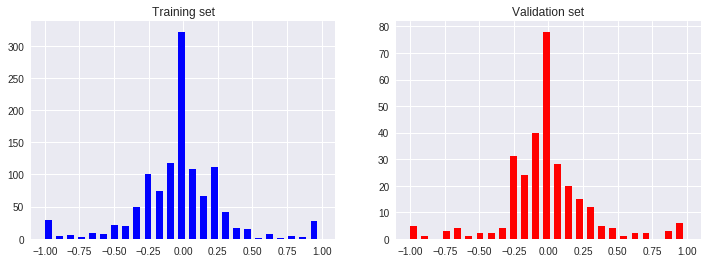

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title("Validation set")

# Augmentation

## Zoom

In [0]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

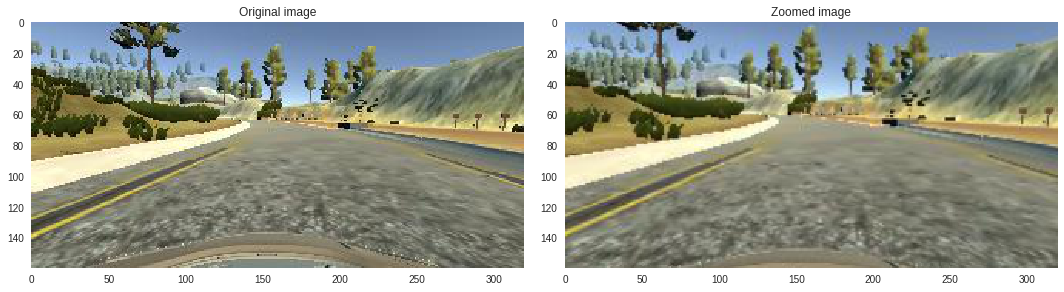

In [0]:
image = image_paths[500]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original image')
axes[0].grid(False)
axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed image')
axes[1].grid(False)

## Pan

In [0]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original image')
axes[0].grid(False)
axes[1].imshow(panned_image)
axes[1].set_title('panned image')
axes[1].grid(False)

## Brightness

In [0]:
def img_random_brightness(image):
    bright = iaa.Multiply((0.2 , 1.2))
    image = bright.augment_image(image)
    return image

In [0]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
br_image = img_random_brightness(original_image)

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original image')
axes[0].grid(False)
axes[1].imshow(br_image)
axes[1].set_title('Random Brightness image')
axes[1].grid(False)

## Flipping

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -1*steering_angle
    return image, steering_angle
    

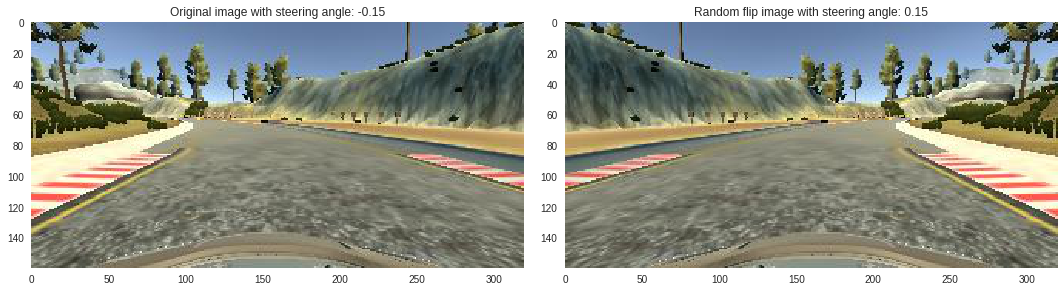

In [0]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
original_image = mpimg.imread(image)
fl_image, steer = img_random_flip(original_image, steerings[random_index])

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title(f'Original image with steering angle: {steerings[random_index]}')
axes[0].grid(False)
axes[1].imshow(fl_image)
axes[1].set_title(f'Random flip image with steering angle: {steer}')
axes[1].grid(False)

## Random Augmentation

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
        
    return image, steering_angle

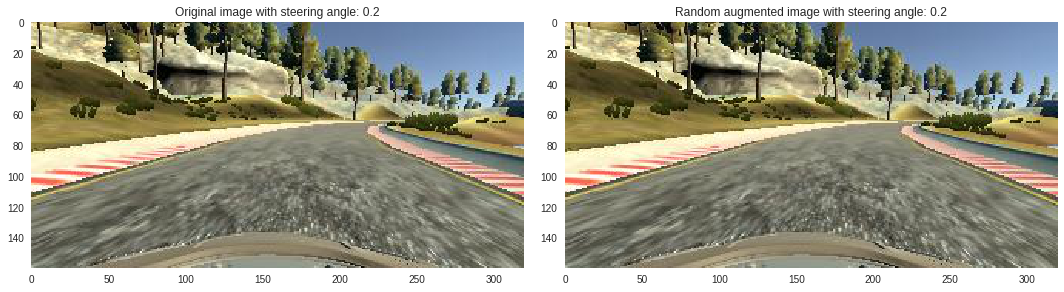

In [0]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
original_image = mpimg.imread(image)
ra_image, steer = random_augment(image_paths[random_index], steerings[random_index])

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title(f'Original image with steering angle: {steerings[random_index]}')
axes[0].grid(False)
axes[1].imshow(ra_image)
axes[1].set_title(f'Random augmented image with steering angle: {steer}')
axes[1].grid(False)

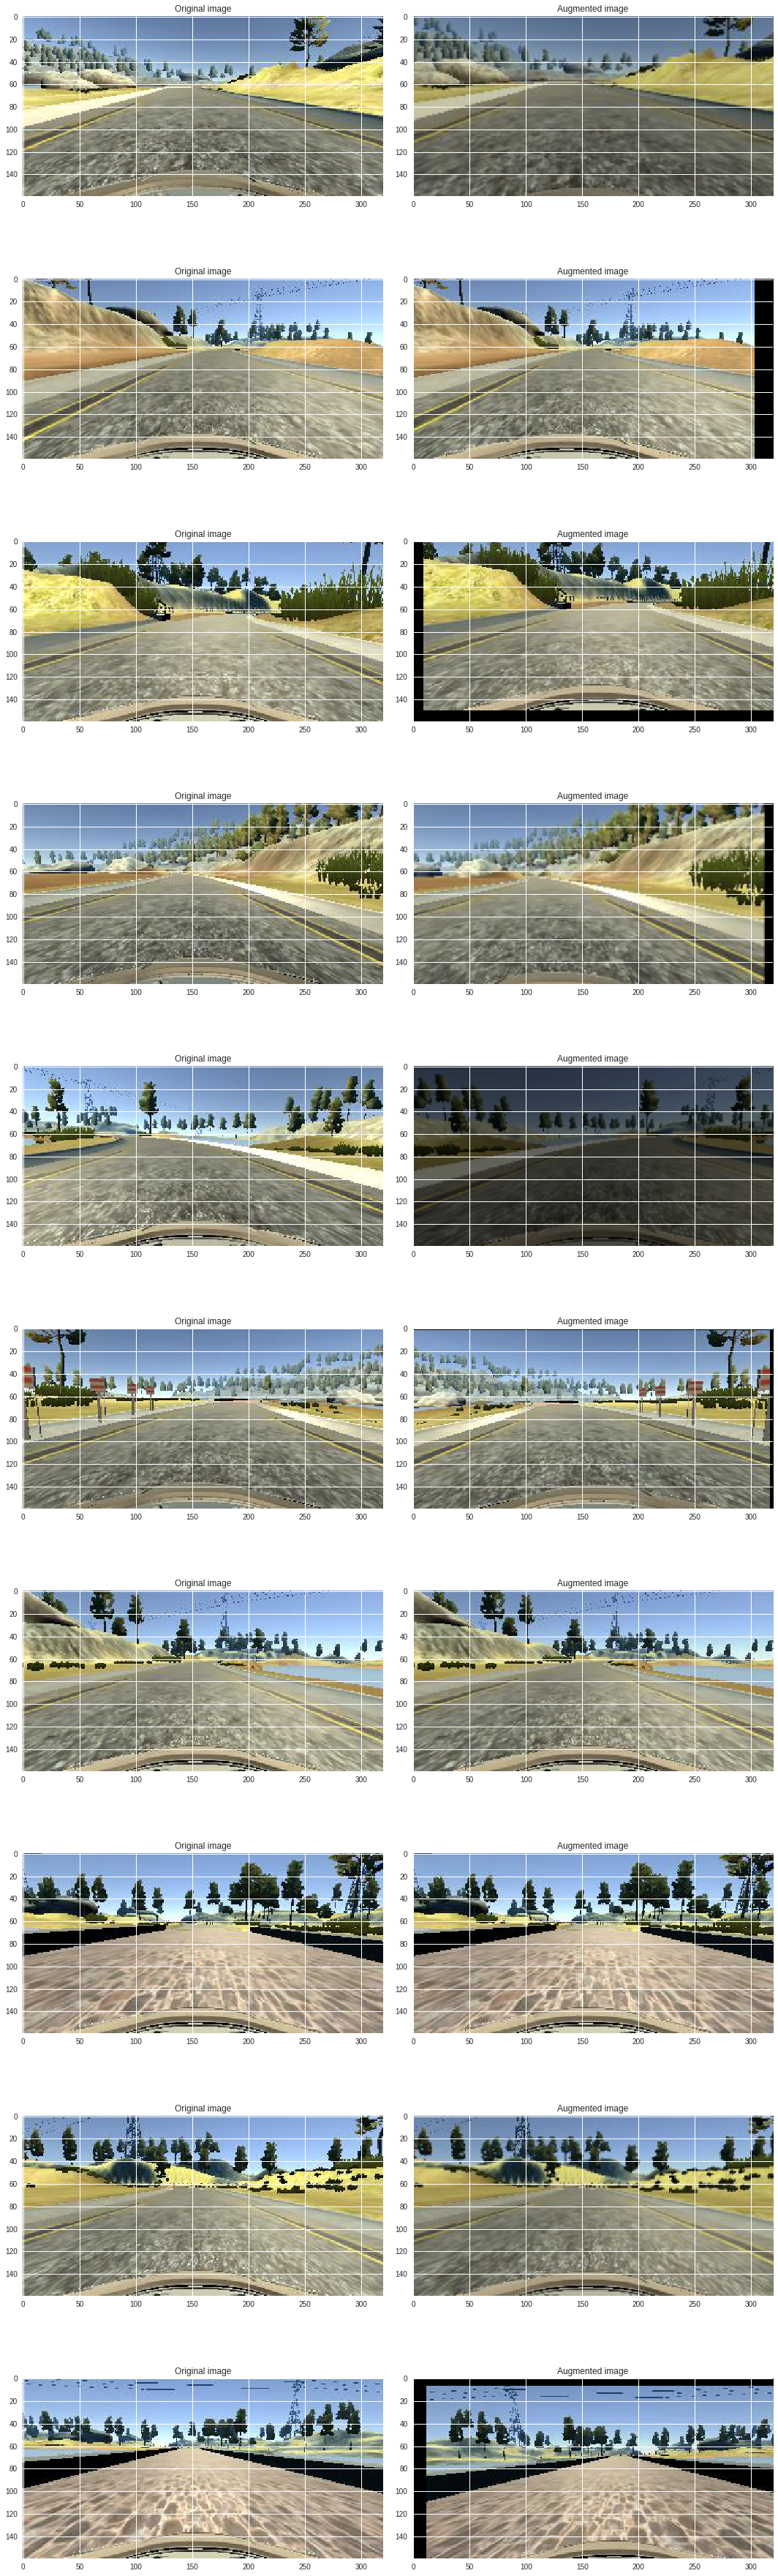

In [0]:
ncol = 2
nrow = 10

fig, axes = plt.subplots(nrow, ncol, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    randnum = random.randint(0, len(image_paths)-1)
    random_image = image_paths[randnum]
    random_steerings = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steerings)
    
    axes[i][0].imshow(original_image)
    axes[i][0].set_title('Original image')
    axes[i][1].imshow(augmented_image)
    axes[i][1].set_title('Augmented image')


# Preprocessing images

In [0]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

def img_preprocess2(img):
    #img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed image')
axes[1].grid(False)

# Batch Generator

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            
            if istraining:
                img, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                img = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
                
            img = img_preprocess2(img)
            batch_img.append(img)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

In [0]:
len(X_valid)

293

In [0]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, True))
X_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, False))

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axes[0].imshow(X_train_gen[0])
axes[0].set_title('Training image')
axes[0].grid(False)

axes[1].imshow(X_valid_gen[0])
axes[1].set_title('Validation image')
axes[1].grid(False)



In [0]:
#X_train = np.array(list(map(img_preprocess, X_train)))
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [0]:
plt.imshow(X_train[1000])
plt.grid(False)
print(X_train.shape)

In [0]:
def nvidia_model():
    '''
    Dropouty jsem vyhodil po použití fit_generatoru
    '''
    
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    
    model.add(Conv2D(64, (3, 3), activation='elu'))
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(lr=1e-4), loss='mse') # 1e-3
    return model
    

In [0]:
model = nvidia_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               115300    
__________

In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, batch_size=100, istraining=True), 
                              steps_per_epoch = 300, 
                              epochs = 15, 
                              validation_data = batch_generator(X_valid, y_valid, batch_size=100, istraining=False), 
                              validation_steps = 200, 
                              verbose = 1, 
                              shuffle = False)

Epoch 1/15
300/300 [==============================] - 161s 538ms/step - loss: 0.0706 - val_loss: 0.0545
Epoch 2/15
300/300 [==============================] - 159s 531ms/step - loss: 0.0621 - val_loss: 0.0611
Epoch 3/15
300/300 [==============================] - 159s 530ms/step - loss: 0.0573 - val_loss: 0.0485
Epoch 4/15
300/300 [==============================] - 160s 532ms/step - loss: 0.0492 - val_loss: 0.0443
Epoch 5/15
300/300 [==============================] - 159s 529ms/step - loss: 0.0449 - val_loss: 0.0389
Epoch 6/15
300/300 [==============================] - 160s 533ms/step - loss: 0.0428 - val_loss: 0.0358
Epoch 7/15
300/300 [==============================] - 160s 532ms/step - loss: 0.0407 - val_loss: 0.0378
Epoch 8/15
300/300 [==============================] - 160s 532ms/step - loss: 0.0399 - val_loss: 0.0296
Epoch 9/15
300/300 [==============================] - 160s 534ms/step - loss: 0.0385 - val_loss: 0.0310
Epoch 10/15
300/300 [==============================] - 160s 532m

Text(0.5, 0, 'Epoch')

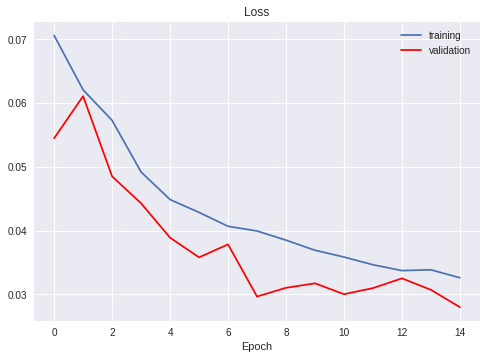

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='red')
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model_fitgen_update.h5')
from google.colab import files
files.download('model_fitgen_update.h5')